In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import calendar
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# import all csvs
test = pd.read_csv('competitive-data-science-predict-future-sales/test.csv')
sales = pd.read_csv('competitive-data-science-predict-future-sales/sales_train.csv')
shops = pd.read_csv('competitive-data-science-predict-future-sales/shops.csv')
items = pd.read_csv('competitive-data-science-predict-future-sales/items.csv')
item_categories = pd.read_csv('competitive-data-science-predict-future-sales/item_categories.csv')

# Perform Data Exporation

In [3]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [4]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [6]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [7]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


# Inspect Data & Find Anomolies

<AxesSubplot:>

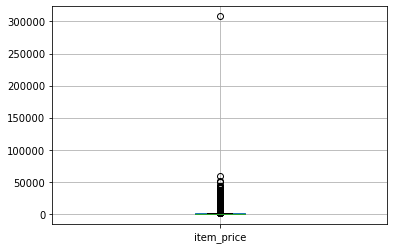

In [8]:
# This box plot shows distinct outliers (e.g., > 10000, < 0)
sales.boxplot(column=['item_price'])

In [9]:
# correct the anomolies
lessthanzero = sales[sales.item_price <= 0]
lessthanzero.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [10]:
sales_train = sales[(sales.item_price > 0) & (sales.item_price < 300000)]

<AxesSubplot:>

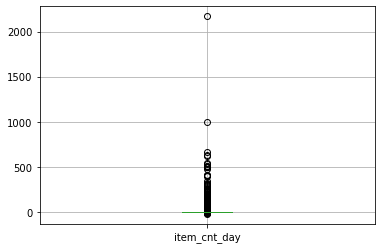

In [11]:
# This box plot shows distinct outliers (e.g., > 750, < 0) - where < 0 may be thought of as returns/refunds
sales_train.boxplot(column=['item_cnt_day'])

In [12]:
sales_train = sales_train[sales_train.item_cnt_day < 750]

<AxesSubplot:>

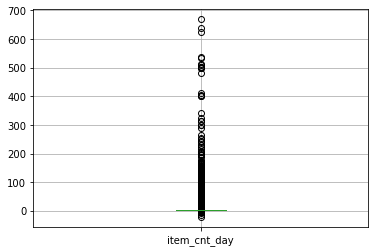

In [13]:
sales_train.boxplot(column=['item_cnt_day'])

# Items Data Prep. & Feature Engineering

In [14]:
pd.options.display.max_rows = 1000
item_categories.head(100)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


In [15]:
# merge items and item_categories data set on 'item_category_id' to begin crafting
# complete data set
items = pd.merge(items, item_categories, on='item_category_id')
items.head()

,item_name,item_id,item_category_id,item_category_name
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD


In [16]:
# generate a feature called 'genre' to categorize into categories and subcategories
items['genre'] = items['item_category_name'].apply(lambda x: x.split('-')[0])
items.head()

,item_name,item_id,item_category_id,item_category_name,genre
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,Кино
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,Кино
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,Кино
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD,Кино
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD,Кино


In [17]:
# adjust some anomolies in the dataset and re-perform feature computation
manual_genre_edit = {
            'Чистые носители (штучные)': 'Чистые носители',
            'Чистые носители (шпиль)' : 'Чистые носители', #Blank Media
            'PC ': 'Аксессуары', ## PC -> Accessories
            'Служебные': 'Служебные ' #Service
            }


items['genre'] = items['genre'].apply(lambda x: manual_genre_edit[x] if x in manual_genre_edit.keys() else x)

In [18]:
# OneHotEncoding - take categories and convert them to numerical data
items['genre_id'] = LabelEncoder().fit_transform(items['genre'])
items.head()

,item_name,item_id,item_category_id,item_category_name,genre,genre_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,Кино,11
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,Кино,11
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,Кино,11
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD,Кино,11
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD,Кино,11


In [19]:
items = items[['item_id', 'item_category_id', 'genre_id']]
items.head()

,item_id,item_category_id,genre_id
0,0,40,11
1,2,40,11
2,3,40,11
3,4,40,11
4,5,40,11


In [20]:
print(shops)

                                          shop_name  shop_id
0                     !Якутск Орджоникидзе, 56 фран        0
1                     !Якутск ТЦ "Центральный" фран        1
2                                  Адыгея ТЦ "Мега"        2
3                    Балашиха ТРК "Октябрь-Киномир"        3
4                          Волжский ТЦ "Волга Молл"        4
5                            Вологда ТРЦ "Мармелад"        5
6                        Воронеж (Плехановская, 13)        6
7                            Воронеж ТРЦ "Максимир"        7
8                      Воронеж ТРЦ Сити-Парк "Град"        8
9                                 Выездная Торговля        9
10                       Жуковский ул. Чкалова 39м?       10
11                       Жуковский ул. Чкалова 39м²       11
12                              Интернет-магазин ЧС       12
13                              Казань ТЦ "Бехетле"       13
14                          Казань ТЦ "ПаркХаус" II       14
15                      

In [21]:
# correct duplicate shops - access a group of rows and columns by labels
sales_train.loc[sales_train.shop_id == 57, 'shop_id'] = 0
sales_train.loc[sales_train.shop_id == 58, 'shop_id'] = 1
sales_train.loc[sales_train.shop_id == 11, 'shop_id'] = 10
sales_train.loc[sales_train.shop_id == 39, 'shop_id'] = 40

test.loc[test.shop_id == 57, 'shop_id'] = 0
test.loc[test.shop_id == 58, 'shop_id'] = 1
test.loc[test.shop_id == 11, 'shop_id'] = 10
test.loc[test.shop_id == 39, 'shop_id'] = 40

# check the amount of unique shops and compare number of unique entires in sales_train dataset
rows = len(sales_train)
unique_test_shop_id = test['shop_id'].unique()
sales_train = sales_train[sales_train['shop_id'].isin(unique_test_shop_id)]
print(rows - len(sales_train))

502311


In [22]:
# begin adding sales train info
# we want to aggregate all the sales count by month instead of days so that we can view trends in the dataset

# ('date_block_num','shop_id','item_id') provides a unique primary key to access each tuple in the data set.
aggregate_count = sales_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
aggregate_count.columns = ['item_cnt_month']
aggregate_count.reset_index(inplace=True)

aggregate_count.head(1000500)

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0
...,...,...,...,...
1000495,23,46,17818,1.0
1000496,23,46,17865,3.0
1000497,23,46,17866,1.0
1000498,23,46,17867,1.0


In [23]:
#aggregate_days_sold = sales_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['count']})
#aggregate_days_sold.columns = ['days_sold']
#aggregate_days_sold.reset_index(inplace=True)
#aggregate_days_sold.head() 

#cc = aggregate_days_sold.loc[aggregate_days_sold['days_sold'] > 31]
#cc.head()

In [24]:
# now that we have the total monthly sales, we want to determine average price per month

aggregate_price = sales_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_price': ['mean']})
aggregate_price.columns = ['mean_price']
aggregate_price.reset_index(inplace=True)

aggregate_price.head()

,date_block_num,shop_id,item_id,mean_price
0,0,0,32,221.0
1,0,0,33,347.0
2,0,0,35,247.0
3,0,0,43,221.0
4,0,0,51,128.5


In [25]:
# we will now perform left join on the data set so that we can combine the two metrics we computed above
merged = aggregate_count.merge(aggregate_price, on=['date_block_num','shop_id','item_id'], how='left')
merged.head()

,date_block_num,shop_id,item_id,item_cnt_month,mean_price
0,0,0,32,6.0,221.0
1,0,0,33,3.0,347.0
2,0,0,35,1.0,247.0
3,0,0,43,1.0,221.0
4,0,0,51,2.0,128.5


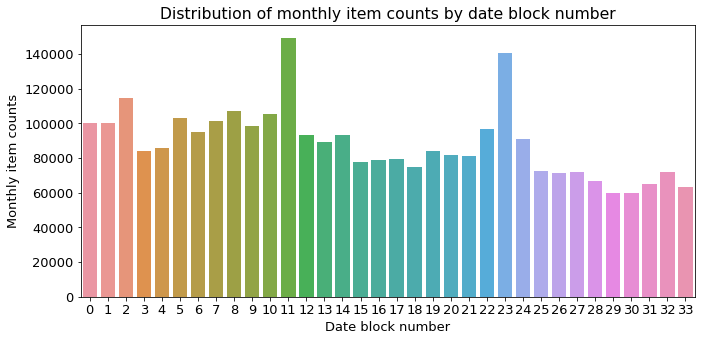

In [26]:
# plot item counts against each month (0-33 months)
# we can see how months 11 + 23 (December) show a spike in sales

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rc('font', size=13)
figure, ax = plt.subplots() 
figure.set_size_inches(11, 5)

# total montly item sales
# group by date, provide sum of item count
group_month_sum = merged.groupby('date_block_num').agg({'item_cnt_month': 'sum'})
group_month_sum = group_month_sum.reset_index()

sns.barplot(x='date_block_num', y='item_cnt_month', data=group_month_sum)
ax.set(title='Distribution of monthly item counts by date block number',
       xlabel='Date block number', 
       ylabel='Monthly item counts');

In [27]:
# append to test data set & set data types
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
# concatenate current dataset and test dataset
merged = pd.concat([merged, test], ignore_index=True, sort=False, keys=['date_block_num','shop_id','item_id'])
merged.fillna(0, inplace=True)


In [28]:
mx = merged.loc[merged['date_block_num'] == 34]
print(len(mx))
mx.head()
print(len(test))


214200
214200


In [29]:
# now, include the items dataset and merge on item id
merged2 = merged.merge(items, on=['item_id'], how='left')
# we also now add shop name for city feature
merged2 = merged2.merge(shops, on='shop_id')
merged2.head()

,date_block_num,shop_id,item_id,item_cnt_month,mean_price,ID,item_category_id,genre_id,shop_name
0,0,0,32,6.0,221.0,0.0,40,11,"!Якутск Орджоникидзе, 56 фран"
1,0,0,33,3.0,347.0,0.0,37,11,"!Якутск Орджоникидзе, 56 фран"
2,0,0,35,1.0,247.0,0.0,40,11,"!Якутск Орджоникидзе, 56 фран"
3,0,0,43,1.0,221.0,0.0,40,11,"!Якутск Орджоникидзе, 56 фран"
4,0,0,51,2.0,128.5,0.0,57,13,"!Якутск Орджоникидзе, 56 фран"


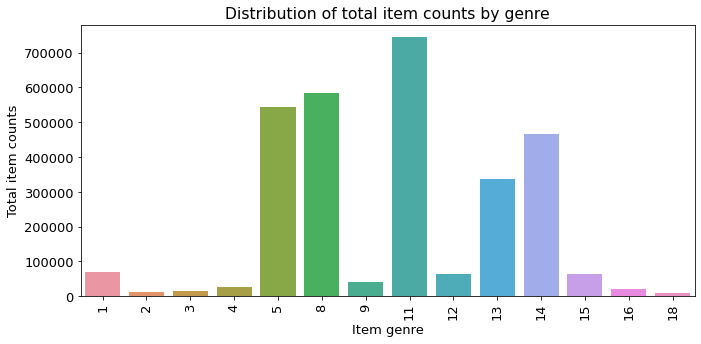

In [30]:
# here, we plot the distribution of total item counts by genre

figure, ax= plt.subplots() 
figure.set_size_inches(11, 5)

# Total item sales by item_category_id
group_cat_sum = merged2.groupby('genre_id').agg({'item_cnt_month': 'sum'})
group_cat_sum = group_cat_sum.reset_index()

# Extract only item categories with total sales > 10,000
group_cat_sum = group_cat_sum[group_cat_sum['item_cnt_month'] > 10000]

sns.barplot(x='genre_id', y='item_cnt_month', data=group_cat_sum)
ax.set(title='Distribution of total item counts by genre',
       xlabel='Item genre', 
       ylabel='Total item counts')
ax.tick_params(axis='x', labelrotation=90) # Rotate X label

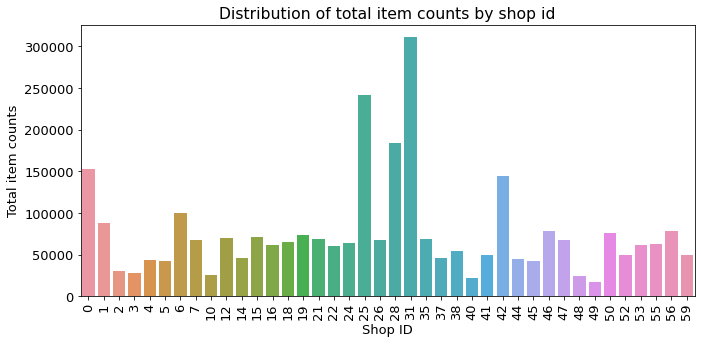

In [31]:
# plot distribution of total item counts by shop ID

figure, ax= plt.subplots() 
figure.set_size_inches(11, 5)

# Total item sales by shop_id
group_shop_sum = merged2.groupby('shop_id').agg({'item_cnt_month': 'sum'})
group_shop_sum = group_shop_sum.reset_index()

group_shop_sum = group_shop_sum[group_shop_sum['item_cnt_month'] > 10000]

sns.barplot(x='shop_id', y='item_cnt_month', data=group_shop_sum)
ax.set(title='Distribution of total item counts by shop id',
       xlabel='Shop ID', 
       ylabel='Total item counts')
ax.tick_params(axis='x', labelrotation=90)

In [32]:
# normalize month into 1-12 format instead of 0-33
merged2["month_id"] = merged2['date_block_num'].apply(lambda dbn: 1 + dbn % 12)
merged2.head()

,date_block_num,shop_id,item_id,item_cnt_month,mean_price,ID,item_category_id,genre_id,shop_name,month_id
0,0,0,32,6.0,221.0,0.0,40,11,"!Якутск Орджоникидзе, 56 фран",1
1,0,0,33,3.0,347.0,0.0,37,11,"!Якутск Орджоникидзе, 56 фран",1
2,0,0,35,1.0,247.0,0.0,40,11,"!Якутск Орджоникидзе, 56 фран",1
3,0,0,43,1.0,221.0,0.0,40,11,"!Якутск Орджоникидзе, 56 фран",1
4,0,0,51,2.0,128.5,0.0,57,13,"!Якутск Орджоникидзе, 56 фран",1


In [33]:
# select may, for example, and let's now inspect for trends during the days of the month
month_inspection = sales_train.loc[sales_train["date_block_num"] == 5]
month_inspection = month_inspection.groupby(['date']).agg({'item_cnt_day': ['sum']})
month_inspection = month_inspection.reset_index()

month_inspection["date"] = month_inspection['date'].apply(lambda x: int(x.split('.')[0]) )
month_inspection.head(5)

,date,item_cnt_day
,,sum
0,1,4823.0
1,2,3663.0
2,3,2733.0
3,4,2753.0
4,5,2892.0


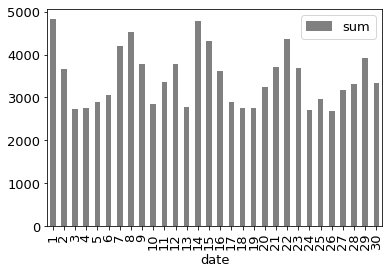

In [34]:
# here, we are able to see that weekends correlate with more sales.
month_inspection.plot.bar(x="date", y="item_cnt_day", color='grey');

In [35]:
# given a month, compute the number of weekends so that we can use as an additional feature
def count_days(date_block_num):
    year = 2013 + date_block_num // 12
    month = 1 + date_block_num % 12
    weeknd_count = len([1 for i in calendar.monthcalendar(year, month) if i[6] != 0])
    return weeknd_count
map_dict = {i: count_days(i) for i in range(35)}

merged2['weeknd_count'] = merged2['date_block_num'].apply(lambda x: map_dict[x])
merged2.head()

,date_block_num,shop_id,item_id,item_cnt_month,mean_price,ID,item_category_id,genre_id,shop_name,month_id,weeknd_count
0,0,0,32,6.0,221.0,0.0,40,11,"!Якутск Орджоникидзе, 56 фран",1,4
1,0,0,33,3.0,347.0,0.0,37,11,"!Якутск Орджоникидзе, 56 фран",1,4
2,0,0,35,1.0,247.0,0.0,40,11,"!Якутск Орджоникидзе, 56 фран",1,4
3,0,0,43,1.0,221.0,0.0,40,11,"!Якутск Орджоникидзе, 56 фран",1,4
4,0,0,51,2.0,128.5,0.0,57,13,"!Якутск Орджоникидзе, 56 фран",1,4


In [36]:
# lagging is a critical feature for our training process.
# it allows for model to look back in time and see how the shop performed in the months before.
# currently, we are looking up to 3 months back
def lag_feature(df, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in [1, 2, 3, 4]:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        df[col+'_lag_'+str(i)] = df[col+'_lag_'+str(i)].astype('float16')
    del tmp
    return df

In [37]:
merged2 = lag_feature(merged2, 'item_cnt_month')
merged2[['item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_4']] = merged2[['item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_4']].fillna(value=0)

In [38]:
# let's take a look here and now we can see we have counts for the number of items sold
# 1 month before, 2 months before, and 3.
merged2.head(500000)

,date_block_num,shop_id,item_id,item_cnt_month,mean_price,ID,item_category_id,genre_id,shop_name,month_id,weeknd_count,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4
0,0,0,32,6.0,221.0,0.0,40,11,"!Якутск Орджоникидзе, 56 фран",1,4,0.0,0.0,0.0,0.0
1,0,0,33,3.0,347.0,0.0,37,11,"!Якутск Орджоникидзе, 56 фран",1,4,0.0,0.0,0.0,0.0
2,0,0,35,1.0,247.0,0.0,40,11,"!Якутск Орджоникидзе, 56 фран",1,4,0.0,0.0,0.0,0.0
3,0,0,43,1.0,221.0,0.0,40,11,"!Якутск Орджоникидзе, 56 фран",1,4,0.0,0.0,0.0,0.0
4,0,0,51,2.0,128.5,0.0,57,13,"!Якутск Орджоникидзе, 56 фран",1,4,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,34,19,10954,0.0,0.0,99303.0,37,11,"Курск ТЦ ""Пушкинский""",11,5,0.0,0.0,0.0,0.0
499996,34,19,10945,0.0,0.0,99304.0,57,13,"Курск ТЦ ""Пушкинский""",11,5,0.0,0.0,0.0,0.0
499997,34,19,10942,0.0,0.0,99305.0,55,13,"Курск ТЦ ""Пушкинский""",11,5,0.0,0.0,1.0,0.0
499998,34,19,10940,0.0,0.0,99306.0,58,13,"Курск ТЦ ""Пушкинский""",11,5,0.0,0.0,0.0,0.0


In [39]:
# create feature city based on location of shop
merged2['city'] = merged2['shop_name'].apply(lambda x: x.split()[0].lower())
merged2.loc[merged2.city == '!якутск', 'city'] = 'якутск' # correct for error
merged2['city_code'] = LabelEncoder().fit_transform(merged2['city'])
merged2 = merged2.drop(columns=['city', 'shop_name'])
merged2.head()
# merged2 = merged2.drop(columns=['shop_name'])

,date_block_num,shop_id,item_id,item_cnt_month,mean_price,ID,item_category_id,genre_id,month_id,weeknd_count,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,city_code
0,0,0,32,6.0,221.0,0.0,40,11,1,4,0.0,0.0,0.0,0.0,26
1,0,0,33,3.0,347.0,0.0,37,11,1,4,0.0,0.0,0.0,0.0,26
2,0,0,35,1.0,247.0,0.0,40,11,1,4,0.0,0.0,0.0,0.0,26
3,0,0,43,1.0,221.0,0.0,40,11,1,4,0.0,0.0,0.0,0.0,26
4,0,0,51,2.0,128.5,0.0,57,13,1,4,0.0,0.0,0.0,0.0,26


In [40]:
# create item first interaction feature - determines if this is the first time the product is being
# purchased at the shop

# if we do not have historical data for the item, flag is set to 1 else 0
first_item_block = merged2.groupby(['item_id'])['date_block_num'].min().reset_index()
first_item_block['item_first_interaction'] = 1

first_shop_item_buy_block = merged2[merged2['date_block_num'] > 0].groupby(['shop_id', 'item_id'])['date_block_num'].min().reset_index()
first_shop_item_buy_block['first_date_block_num'] = first_shop_item_buy_block['date_block_num']

merged2 = pd.merge(merged2, first_item_block[['item_id', 'date_block_num', 'item_first_interaction']], on=['item_id', 'date_block_num'], how='left')
merged2 = pd.merge(merged2, first_shop_item_buy_block[['item_id', 'shop_id', 'first_date_block_num']], on=['item_id', 'shop_id'], how='left')

merged2['first_date_block_num'].fillna(100, inplace=True)
merged2['shop_item_sold_before'] = (merged2['first_date_block_num'] < merged2['date_block_num']).astype('int8')
merged2.drop(['first_date_block_num'], axis=1, inplace=True)

merged2['item_first_interaction'].fillna(0, inplace=True)
merged2['shop_item_sold_before'].fillna(0, inplace=True)
 
merged2['item_first_interaction'] = merged2['item_first_interaction'].astype('int8')  
merged2['shop_item_sold_before'] = merged2['shop_item_sold_before'].astype('int8')
merged2.head(1000000)

,date_block_num,shop_id,item_id,item_cnt_month,mean_price,ID,item_category_id,genre_id,month_id,weeknd_count,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,city_code,item_first_interaction,shop_item_sold_before
0,0,0,32,6.0,221.0,0.0,40,11,1,4,0.0,0.0,0.0,0.0,26,1,0
1,0,0,33,3.0,347.0,0.0,37,11,1,4,0.0,0.0,0.0,0.0,26,1,0
2,0,0,35,1.0,247.0,0.0,40,11,1,4,0.0,0.0,0.0,0.0,26,1,0
3,0,0,43,1.0,221.0,0.0,40,11,1,4,0.0,0.0,0.0,0.0,26,1,0
4,0,0,51,2.0,128.5,0.0,57,13,1,4,0.0,0.0,0.0,0.0,26,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,20,38,9805,1.0,199.0,0.0,40,11,9,4,0.0,1.0,0.0,0.0,15,0,1
999996,20,38,9845,1.0,149.0,0.0,40,11,9,4,2.0,0.0,1.0,0.0,15,0,1
999997,20,38,9986,1.0,199.0,0.0,37,11,9,4,0.0,0.0,0.0,0.0,15,0,1
999998,20,38,10006,1.0,279.3,0.0,41,11,9,4,0.0,1.0,0.0,0.0,15,0,1


In [41]:

y = merged2.loc[ (merged2['date_block_num'] == 0) & (merged2['shop_id'] == 13) & (merged2['item_id'] == 32)]
y.head()

,date_block_num,shop_id,item_id,item_cnt_month,mean_price,ID,item_category_id,genre_id,month_id,weeknd_count,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,city_code,item_first_interaction,shop_item_sold_before


In [42]:
##Add target encoding for item/shop for last 3 months 
##item_id_target_mean = merged2.groupby(['date_block_num','item_id', 'shop_id'])['item_cnt_month'].mean().reset_index().rename(columns={
    ##"item_cnt_month": "item_shop_target_enc"}, errors="raise")

##merged2 = pd.merge(merged2, item_id_target_mean, on=['date_block_num','item_id', 'shop_id'], how='left')

##merged2.head()

In [43]:
#xm = merged2.loc[merged2['item_cnt_month'] != merged2['item_shop_target_enc']]
#xm.head()


In [44]:
df2 = merged2.loc[merged2['date_block_num'] == 34]
df2.head()


,date_block_num,shop_id,item_id,item_cnt_month,mean_price,ID,item_category_id,genre_id,month_id,weeknd_count,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,city_code,item_first_interaction,shop_item_sold_before
64793,34,0,5037,0.0,0.0,137700.0,19,5,11,5,1.0,0.0,1.0,0.0,26,0,1
64794,34,0,5320,0.0,0.0,137701.0,55,13,11,5,0.0,0.0,0.0,0.0,26,1,0
64795,34,0,5233,0.0,0.0,137702.0,19,5,11,5,1.0,4.0,1.0,1.0,26,0,1
64796,34,0,5232,0.0,0.0,137703.0,23,5,11,5,1.0,1.0,3.0,0.0,26,0,1
64797,34,0,5268,0.0,0.0,137704.0,20,5,11,5,0.0,0.0,0.0,0.0,26,1,0


In [50]:
# create final dataset
# split data into training validation and testing
# we originally put them all together to make feature engineering easier
df = merged2
X_train = df[(df.date_block_num >= 4) & (df.date_block_num < 33)].drop(['item_cnt_month'], axis=1)
Y_train = df[(df.date_block_num >= 4) & (df.date_block_num < 33)]['item_cnt_month']
Z_train = df[(df.date_block_num >= 4) & (df.date_block_num < 34)]

X_valid = df[df.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = df[df.date_block_num == 33]['item_cnt_month']

X_test = df[df.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [46]:
X_train.head(10)

,date_block_num,shop_id,item_id,mean_price,ID,item_category_id,genre_id,month_id,weeknd_count,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,city_code,item_first_interaction,shop_item_sold_before
10171,4,0,30,399.0,0.0,40,11,5,4,3.0,24.0,31.0,0.0,26,0,1
10172,4,0,31,699.0,0.0,37,11,5,4,1.0,10.0,11.0,0.0,26,0,1
10173,4,0,32,349.0,0.0,40,11,5,4,6.0,12.0,10.0,6.0,26,0,1
10174,4,0,33,499.0,0.0,37,11,5,4,0.0,0.0,3.0,3.0,26,0,1
10175,4,0,37,149.0,0.0,40,11,5,4,4.0,0.0,0.0,0.0,26,0,1
10176,4,0,51,249.0,0.0,57,13,5,4,0.0,0.0,3.0,2.0,26,0,1
10177,4,0,52,249.0,0.0,57,13,5,4,0.0,1.0,0.0,0.0,26,0,1
10178,4,0,60,249.0,0.0,43,12,5,4,0.0,0.0,0.0,0.0,26,0,0
10179,4,0,63,149.0,0.0,40,11,5,4,0.0,0.0,0.0,0.0,26,0,0
10180,4,0,84,149.0,0.0,40,11,5,4,0.0,0.0,0.0,0.0,26,0,0


In [51]:
import tensorflow as tf
from tensorflow.keras import layers

features = ['date_block_num', 'shop_id', 'item_id', 'mean_price','item_category_id', 'genre_id', 'month_id','item_cnt_month_lag_1','item_cnt_month_lag_2','item_cnt_month_lag_3','item_cnt_month_lag_4', "city_code", "item_first_interaction", "shop_item_sold_before"]
training_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(Z_train[features].values, tf.float32),
            tf.cast(Z_train['item_cnt_month'].values, tf.float32)
        )
    )
)

In [52]:

def get_compiled_modelX():
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(500, activation='sigmoid', input_shape=(len(features),)),
    layers.Dropout(0.5),
    tf.keras.layers.Dense(200, activation='sigmoid'),
    layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation='relu'),
    layers.Dropout(0.5),
    tf.keras.layers.Dense(20, activation='relu'),
    layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
  ])

  model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.15),
    loss='mean_absolute_error')
    
  return model



In [54]:
model = get_compiled_modelX()

model.fit(Z_train[features].values, Z_train['item_cnt_month'].values, epochs=5)

Epoch 1/5
35813/35813 [==============================] - 85s 2ms/step - loss: 1.3485
Epoch 2/5
35813/35813 [==============================] - 84s 2ms/step - loss: 1.3005
Epoch 3/5
35813/35813 [==============================] - 86s 2ms/step - loss: 1.2991
Epoch 4/5
35813/35813 [==============================] - 85s 2ms/step - loss: 1.2872
Epoch 5/5
35813/35813 [==============================] - 84s 2ms/step - loss: 1.2890


In [57]:
# predict & export submissions
test = pd.read_csv('competitive-data-science-predict-future-sales/test.csv')
Y_test = model.predict(X_test[features]).clip(0, 20)



submission = pd.DataFrame({ "ID": test.index, "item_cnt_month": Y_test.flatten() }) 
submission.to_csv('gbm_submissionXYZZA.csv', index=False)

In [ ]:
print(len(Y_test))

In [ ]:
print(len(test))

In [ ]:
test.head()


In [ ]:
print(Y_test)


In [ ]:

print(len(X_test))